# Forecasting Non-Stationary Time Series

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Johnson & Johnson Dataset

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


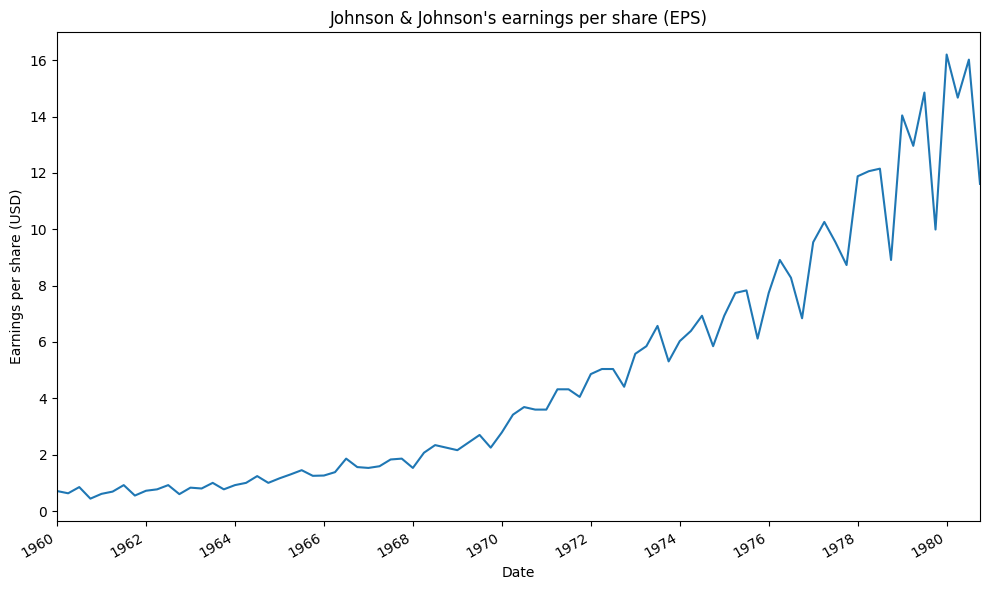

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.set_title("Johnson & Johnson's earnings per share (EPS)")
ax.set_xlim(0, 83)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### Is it Stationary?

In [20]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['data'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 2.7420165734574766
p-value: 1.0

p-value > alpha; H0: Not Stationary


We need to determine how many times the series must be differenced to become
stationary. This will then set the order of integration d. We can apply a first-order differencing and test for stationarity.

In [25]:
# First-Order differencing
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.4074097636380437
p-value: 0.9088542416911309

p-value > alpha; H0: Not Stationary


In [27]:
# Second-Order differencing
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result2 = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.5851628747931694
p-value: 0.006051099869603393

p-value < alpha; Ha: Stationary


It took two rounds of differencing to make our data stationary, which means that our order of integration is 2,
so d = 2.